# Analytics Case Study: Customer Growth, Retention & Customer Value

This case study analyzes an anonymized e-commerce orders dataset to explore
customer retention, growth dynamics, lifetime value, and churn risk.

The analysis demonstrates how analytics engineering techniques can be used to
support acquisition strategy, revenue sustainability assessment, and customer
success prioritization in a consumer product context.

**Note**: This notebook is designed to run in Google Colab.

## Analytics Deep Dive: Customer Growth & Retention

This analysis explores customer growth, retention, lifetime value, and churn risk using an e-commerce orders dataset. The goal is to understand **true retention behavior**, **customer value segmentation**, and the **implications for acquisition, retention, and customer success strategy**.

Key analytical principles used:
- Cohort-based retention analysis at a monthly grain
- Clear metric definitions and customer lifecycle modeling
- Customer-level risk scoring and value-based prioritization
- Separation of transformation logic (SQL) and analytical reasoning (Python)

The notebook is structured to mirror a production analytics workflow, with a curated customer–month analytical layer used consistently across analyses to ensure metric consistency, interpretability, and actionability.

## Executive Summary

- **Retention is low overall**, with a large share of early churn driven by low-value, single-purchase customers. Improving early lifecycle engagement has a greater impact on sustainable growth than relying on long-term retention or resurrection.

- **Resurrection behavior exists but is limited**, suggesting win-back efforts should be targeted selectively rather than applied broadly.

- **Revenue growth is primarily acquisition-led**, with new customer revenue largely offsetting churn, while expansion from existing customers remains limited. This indicates that growth sustainability depends on continued acquisition efficiency and improved retention over time.

- **Customer lifetime value varies significantly by early behavior**. Repeat purchasers and high-value customers generate substantially higher predicted CLV than the average customer.

- **Segment-level CLV enables differentiated acquisition strategy**, with high-value segments supporting meaningfully higher CAC thresholds under a 3:1 LTV:CAC framework.

- Early lifecycle signals provide a practical foundation for **allocating acquisition spend and prioritizing retention investment**, even in the absence of long historical customer lifetimes.

- **Churn risk and customer value can be combined into a clear prioritization framework**, enabling Customer Success teams to focus limited resources on high-value customers showing early warning signs of disengagement. Historical return patterns indicate that retention interventions are most effective when applied within the first 30–90 days of inactivity.

# Environment Setup

This section sets up the analysis environment and core libraries used throughout
the notebook. DuckDB is used for SQL-based transformations, while Python is used
for analytical modeling and interpretation.

In [ ]:
!pip install duckdb pandas matplotlib seaborn -q

In [ ]:
# Imports & Configuration
import pandas as pd
import numpy as np

import duckdb

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
vmin = 0
vmax = 100

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the CSV file into a pandas DataFrame - Specifiy file path accordingly
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Analytics Case Studies/orders.csv'
orders_df = pd.read_csv(csv_file_path)

orders_df.head()

,invoice_id,line_item_id,user_id,item_id,item_name,item_category,price,created_at,paid_at
0,192320.0,83118.0,178481.0,3526.0,digital apparatus,apparatus,330.0,2017-06-28 21:14:25,2017-06-27 21:19:39
1,192320.0,207309.0,178481.0,1514.0,miniature apparatus cleaner,apparatus,99.0,2017-06-28 21:14:25,2017-06-27 21:19:39
2,192320.0,392027.0,178481.0,3712.0,miniature apparatus cleaner,apparatus,99.0,2017-06-28 21:14:25,2017-06-27 21:19:39
3,80902.0,243831.0,154133.0,3586.0,reflective instrument,instrument,57.2,2016-10-09 06:57:30,2016-10-07 10:08:10
4,80902.0,399806.0,154133.0,1061.0,extra-strength instrument charger,instrument,17.6,2016-10-09 06:57:30,2016-10-07 10:08:10


# Dataset Overview & Initial Validation

Each row represents a line item within an order.  
The expected analytical grain varies by use case, but most analyses will be performed at:
- **Order-level** (invoice_id)
- **Customer-month level** (user_id × month)

Before analysis:
- Identifier columns were explicitly cast to integers.
- Timestamps were parsed with coercion to handle malformed values defensively.

These steps ensure consistent behavior in downstream SQL-based cohort and retention analyses.

In [ ]:
# Basic Schema & Type Checks
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47402 entries, 0 to 47401
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invoice_id     47402 non-null  float64
 1   line_item_id   47402 non-null  float64
 2   user_id        47402 non-null  float64
 3   item_id        47402 non-null  float64
 4   item_name      47402 non-null  object 
 5   item_category  47402 non-null  object 
 6   price          47402 non-null  float64
 7   created_at     47402 non-null  object 
 8   paid_at        47402 non-null  object 
dtypes: float64(5), object(4)
memory usage: 3.3+ MB


In [ ]:
# Identifier normalization
id_columns = ["invoice_id", "line_item_id", "user_id", "item_id"]

for col in id_columns:
    # Assert values are integer-like before casting
    if not (orders_df[col] % 1 == 0).all():
        raise ValueError(f"Non-integer values detected in {col}")
    orders_df[col] = orders_df[col].astype("int64")

orders_df["price"] = orders_df["price"].astype("float64")

In [ ]:
# Parse dates
orders_df["created_at"] = pd.to_datetime(
    orders_df["created_at"], errors="coerce", utc=True
)
orders_df["paid_at"] = pd.to_datetime(
    orders_df["paid_at"], errors="coerce", utc=True
)

# Derived fields & month normalization
orders_df["order_date"] = orders_df["paid_at"].dt.date
orders_df["order_month"] = (
    orders_df["paid_at"]
    .dt.to_period("M")
    .dt.to_timestamp()
)

/tmp/ipython-input-3531184034.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  .dt.to_period("M")


In [ ]:
# Verify date parsing (expected output: 0, no dates missing)
orders_df[["created_at", "paid_at"]].isna().sum()

,0
created_at,0
paid_at,0


In [ ]:
# Validate Schema Changes
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47402 entries, 0 to 47401
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   invoice_id     47402 non-null  int64              
 1   line_item_id   47402 non-null  int64              
 2   user_id        47402 non-null  int64              
 3   item_id        47402 non-null  int64              
 4   item_name      47402 non-null  object             
 5   item_category  47402 non-null  object             
 6   price          47402 non-null  float64            
 7   created_at     47402 non-null  datetime64[ns, UTC]
 8   paid_at        47402 non-null  datetime64[ns, UTC]
 9   order_date     47402 non-null  object             
 10  order_month    47402 non-null  datetime64[ns]     
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 4.0+ MB


We should now see the ID fields as `int64` and timestamps as `datetime64[ns, UTC]`

In [ ]:
# Invoice-User integrity
assert orders_df.groupby("invoice_id")["user_id"].nunique().eq(1).all()
# Non-negative Prices
assert (orders_df["price"] >= 0).all(), "Negative prices detected"

In [ ]:
# Validate timestamp ordering
invalid_timestamps = orders_df[
    orders_df["paid_at"] < orders_df["created_at"]
]

invalid_timestamps.shape[0] / orders_df.shape[0]

0.3925783722205814

During validation, a significant number of rows (~39%) show `paid_at` earlier than `created_at`. This indicates that `created_at` does not represent the order creation time and therefore does not align with the schema definition provided in the dataset overview.

For all customer behavior, cohorting, retention, and CLV analyses, `paid_at` is treated as the authoritative transaction timestamp.

# Data Modeling in DuckDB

This section constructs the core analytical tables used throughout the notebook.
DuckDB is used to perform SQL-based transformations and aggregations, producing
stable order-level and customer–month datasets that are reused consistently across retention, growth, and CLV analyses.

In [ ]:
# Data Loading & DuckDB Connection
con = duckdb.connect(database=":memory:")

con.register("orders", orders_df)

In [ ]:
# Quick data validation checks in DuckDB
con.execute("""
SELECT
    COUNT(*) AS total_rows,
    COUNT(DISTINCT invoice_id) AS total_orders,
    COUNT(DISTINCT user_id) AS total_customers,
    SUM(CASE WHEN price IS NULL THEN 1 ELSE 0 END) AS null_price_rows
FROM orders
""").df()

,total_rows,total_orders,total_customers,null_price_rows
0,47402,18971,17463,0.0


Basic integrity checks confirm expected row counts, unique identifiers, and no critical null values in revenue fields.
These checks ensure downstream retention and CLV metrics are computed on reliable data.

## Analytical Base Table

A customer-month fact table was created to serve as a reusable analytical layer.
This mirrors a gold-layer model in a modern analytics stack and ensures consistent metric definitions across analyses.

In [ ]:
#Customer-Month Aggregation
customer_month_df = con.execute("""
WITH orders_enriched AS (
    SELECT
        user_id,
        invoice_id,
        order_month,
        SUM(price) AS order_revenue
    FROM orders
    GROUP BY user_id, invoice_id, order_month
),
customer_month AS (
    SELECT
        user_id,
        order_month,
        COUNT(DISTINCT invoice_id) AS orders,
        SUM(order_revenue) AS revenue
    FROM orders_enriched
    GROUP BY user_id, order_month
)
SELECT * FROM customer_month
ORDER BY user_id, order_month
""").df()

customer_month_df.head()

# Register table in DuckDB
con.register("customer_month", customer_month_df)

# Question 1 - Cohort Retention Analysis

This analysis examines customer retention and resurrection patterns using monthly acquisition cohorts.

Customers are assigned to cohorts based on the calendar month of their **first completed purchase** (`paid_at`). All retention and lifecycle metrics are measured relative to this cohort month.

**Note**: All retention and resurrection metrics are computed as ratios internally and presented as percentages for readability.

In [ ]:
# First Purchase per Customer
first_purchase_df = con.execute("""
SELECT
    user_id,
    MIN(order_month) AS first_purchase_month
FROM customer_month
GROUP BY user_id
""").df()

In [ ]:
# One row per user
assert first_purchase_df["user_id"].is_unique
# No null cohort assignments
assert first_purchase_df["first_purchase_month"].notna().all()

In [ ]:
# Customer Cohorts Table
customer_cohorts_df = first_purchase_df.copy()
customer_cohorts_df = customer_cohorts_df.rename(
    columns={"first_purchase_month": "cohort_month"}
)

# Register table in DuckDB
con.register("customer_cohorts", customer_cohorts_df)

In [ ]:
# Cohort Activity Table
cohort_activity_df = con.execute("""
SELECT
    cm.user_id,
    cc.cohort_month,
    cm.order_month,
    cm.orders,
    cm.revenue,
    DATE_DIFF('month', cc.cohort_month, cm.order_month) AS cohort_age
FROM customer_month cm
JOIN customer_cohorts cc
  ON cm.user_id = cc.user_id
ORDER BY cm.user_id, cm.order_month
""").df()

# Register table in DuckDB
con.register("cohort_activity", cohort_activity_df)

cohort_activity_df.head()

,user_id,cohort_month,order_month,orders,revenue,cohort_age
0,17,2013-05-01,2013-05-01,1,243.00,0
1,25,2013-05-01,2013-05-01,1,1.80,0
2,63,2013-07-01,2013-07-01,1,585.00,0
3,65,2013-05-01,2013-05-01,1,44.50,0
4,69,2013-08-01,2013-08-01,1,9.42,0


In [ ]:
# No negative cohort ages
assert (cohort_activity_df["cohort_age"] >= 0).all()
# Each customer must have cohort_age == 0 at least once
assert (cohort_activity_df.groupby("user_id")["cohort_age"].min() == 0).all()

## Standard Cohort Retention

A customer is considered **retained** in a given month if they place at least one order
during that cohort-relative month (`cohort_age`).

Retention rates are calculated as:
retained customers ÷ cohort size

In [ ]:
# Cohort Sizes
cohort_size_df = con.execute("""
SELECT
    cohort_month,
    COUNT(DISTINCT user_id) AS cohort_size
FROM customer_cohorts
GROUP BY cohort_month
ORDER BY cohort_month
""").df()

In [ ]:
# Active Customers by Cohort Month & Age
cohort_active_df = con.execute("""
SELECT
    cohort_month,
    cohort_age,
    COUNT(DISTINCT user_id) AS active_customers
FROM cohort_activity
WHERE cohort_age BETWEEN 0 AND 12
GROUP BY cohort_month, cohort_age
ORDER BY cohort_month, cohort_age
""").df()

In [ ]:
# Retention Rates
cohort_retention_df = cohort_active_df.merge(
    cohort_size_df,
    on="cohort_month",
    how="left"
)

cohort_retention_df["retention_rate"] = (
    cohort_retention_df["active_customers"]
    / cohort_retention_df["cohort_size"]
)

In [ ]:
# Pivot Table to Standard Cohort Matrix
cohort_retention_pivot = cohort_retention_df.pivot(
    index="cohort_month",
    columns="cohort_age",
    values="retention_rate"
).sort_index(ascending=False).round(3)

In [ ]:
# Month 0 retention must be 100%
assert (cohort_retention_pivot[0] == 1.0).all()
# Retention cannot exceed 100% (we ingore NaN values)
assert (cohort_retention_pivot.stack() <= 1.0).all()

Month 0 (acquisition month) is included internally for validation purposes (100% retention by definition), but excluded from reported retention metrics. All reported retention rates reflect months 1–12.

In [ ]:
# Filter to Months 1–12
cohort_retention_pivot_report = cohort_retention_pivot.loc[:, 1:12]

In [ ]:
# Main cohort retention table with monthly percentages
cohort_retention_pct = (cohort_retention_pivot_report * 100).round(1)
cohort_retention_pct.head()

cohort_age,1,2,3,4,5,6,7
cohort_month,,,,,,,
2018-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,2.1,0.2,NaN,NaN,NaN,NaN,NaN
2018-03-01,2.0,1.3,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.8,1.4,1.6,0.2,NaN,NaN,NaN


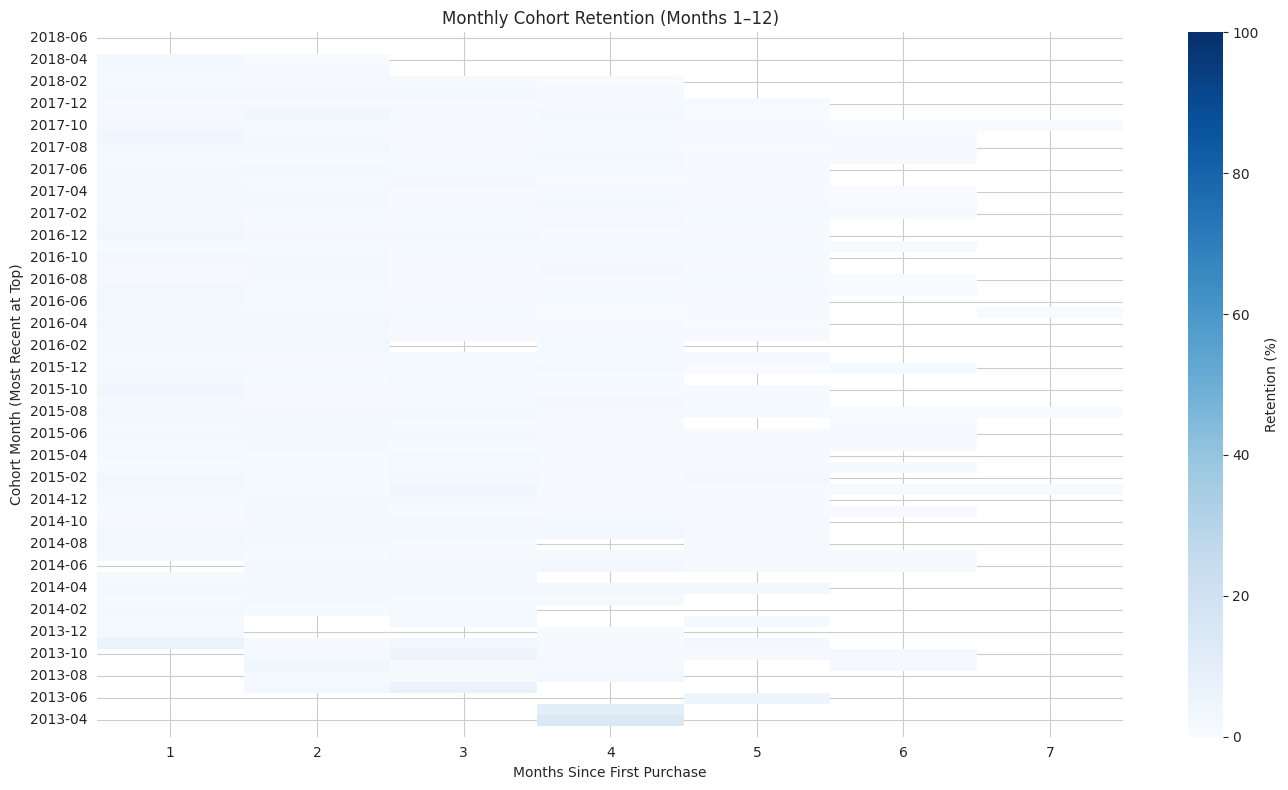

In [ ]:
# Format Cohort Month Axis for plotting
cohort_retention_pct.index = (
    cohort_retention_pct.index
    .strftime("%Y-%m")
)

# Standard retention heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    cohort_retention_pct,
    cmap="Blues",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"label": "Retention (%)"},
    linewidths=0
)

plt.title("Monthly Cohort Retention (Months 1–12)")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month (Most Recent at Top)")
plt.tight_layout()
plt.show()

Note: With multiple years of cohorts, individual rows are narrow. The heatmap is intended to highlight overall retention patterns and differences between early and later lifecycle months, rather than cohort-specific anomalies.

## Quality Retention

We first established standard cohort retention, then refine it by excluding low-value, single-purchase customers (quality retention), before analyzing resurrection behavior. This ensures each layer builds on a validated
foundation and allows clearer interpretation of business impact at each step.

Quality retention excludes customers who made only a single low-value purchase (defined as total lifetime spend < $50 and only one order).

This adjustment helps isolate retention patterns of customers with meaningful engagement, providing a clearer signal for sustainable growth.

In [ ]:
#  Customer Lifetime Summary
customer_lifetime_df = con.execute("""
SELECT
    user_id,
    COUNT(DISTINCT invoice_id) AS total_orders,
    SUM(price) AS lifetime_revenue
FROM orders
GROUP BY user_id
""").df()

In [ ]:
# Quality Flag
customer_lifetime_df["is_low_quality"] = (
    (customer_lifetime_df["total_orders"] == 1) &
    (customer_lifetime_df["lifetime_revenue"] < 50)
)

customer_lifetime_df["is_low_quality"].value_counts()

,count
is_low_quality,
False,12692
True,4771


In [ ]:
# High-Quality Customers
high_quality_customers_df = customer_lifetime_df[
    ~customer_lifetime_df["is_low_quality"]
][["user_id"]]

# Register table in DuckDB
con.register("high_quality_customers", high_quality_customers_df)

In [ ]:
# Quality Cohort Activity
quality_cohort_activity_df = con.execute("""
SELECT
    ca.*
FROM cohort_activity ca
JOIN high_quality_customers hq
  ON ca.user_id = hq.user_id
""").df()

quality_cohort_activity_df.head()

,user_id,cohort_month,order_month,orders,revenue,cohort_age
0,17,2013-05-01,2013-05-01,1,243.0,0
1,63,2013-07-01,2013-07-01,1,585.0,0
2,94,2013-07-01,2013-07-01,1,852.0,0
3,98,2013-08-01,2013-08-01,1,390.0,0
4,100,2013-04-01,2013-04-01,1,209.0,0


In [ ]:
# Quality Cohort Sizes
quality_cohort_size_df = con.execute("""
SELECT
    cohort_month,
    COUNT(DISTINCT user_id) AS cohort_size
FROM quality_cohort_activity_df
GROUP BY cohort_month
ORDER BY cohort_month
""").df()

In [ ]:
# Active High-Quality Customers
quality_cohort_active_df = con.execute("""
SELECT
    cohort_month,
    cohort_age,
    COUNT(DISTINCT user_id) AS active_customers
FROM quality_cohort_activity_df
WHERE cohort_age BETWEEN 0 AND 12
GROUP BY cohort_month, cohort_age
ORDER BY cohort_month, cohort_age
""").df()

In [ ]:
# Quality Retention Table
quality_retention_df = quality_cohort_active_df.merge(
    quality_cohort_size_df,
    on="cohort_month",
    how="left"
)

quality_retention_df["retention_rate"] = (
    quality_retention_df["active_customers"] /
    quality_retention_df["cohort_size"]
)

# Pivot
quality_retention_pivot = (
    quality_retention_df
    .pivot(index="cohort_month", columns="cohort_age", values="retention_rate")
    .sort_index(ascending=False)
    .round(3)
)

In [ ]:
# Sanity Check
assert (quality_retention_pivot.stack() <= 1.0).all()

In [ ]:
# Standard vs Quality retention comparison at 3-month mark (percentages)
comparison_df = pd.DataFrame({
    "standard_retention_m3_pct": cohort_retention_pivot[3] * 100,
    "quality_retention_m3_pct": quality_retention_pivot[3] * 100
}).dropna()

comparison_df.mean().round(1)

,0
standard_retention_m3_pct,1.8
quality_retention_m3_pct,2.5


After excluding low-value single-purchase customers, retention rates increase materially. This suggests that a significant portion of early churn
comes from low-intent or low-quality acquisitions, rather than disengagement among valuable customers.

These findings support differentiated acquisition and onboarding strategies based on expected customer value.

In [ ]:
# Filter to Months 1–12
quality_retention_pivot_report = quality_retention_pivot.loc[:, 1:12]

In [ ]:
# Quality Retention Table with monthly percentages
quality_retention_pct = (quality_retention_pivot_report * 100).round(1)
quality_retention_pct.head()

cohort_age,1,2,3,4,5,6,7
cohort_month,,,,,,,
2018-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,3.0,0.3,NaN,NaN,NaN,NaN,NaN
2018-03-01,2.7,1.8,NaN,NaN,NaN,NaN,NaN
2018-02-01,2.5,1.9,2.2,0.3,NaN,NaN,NaN


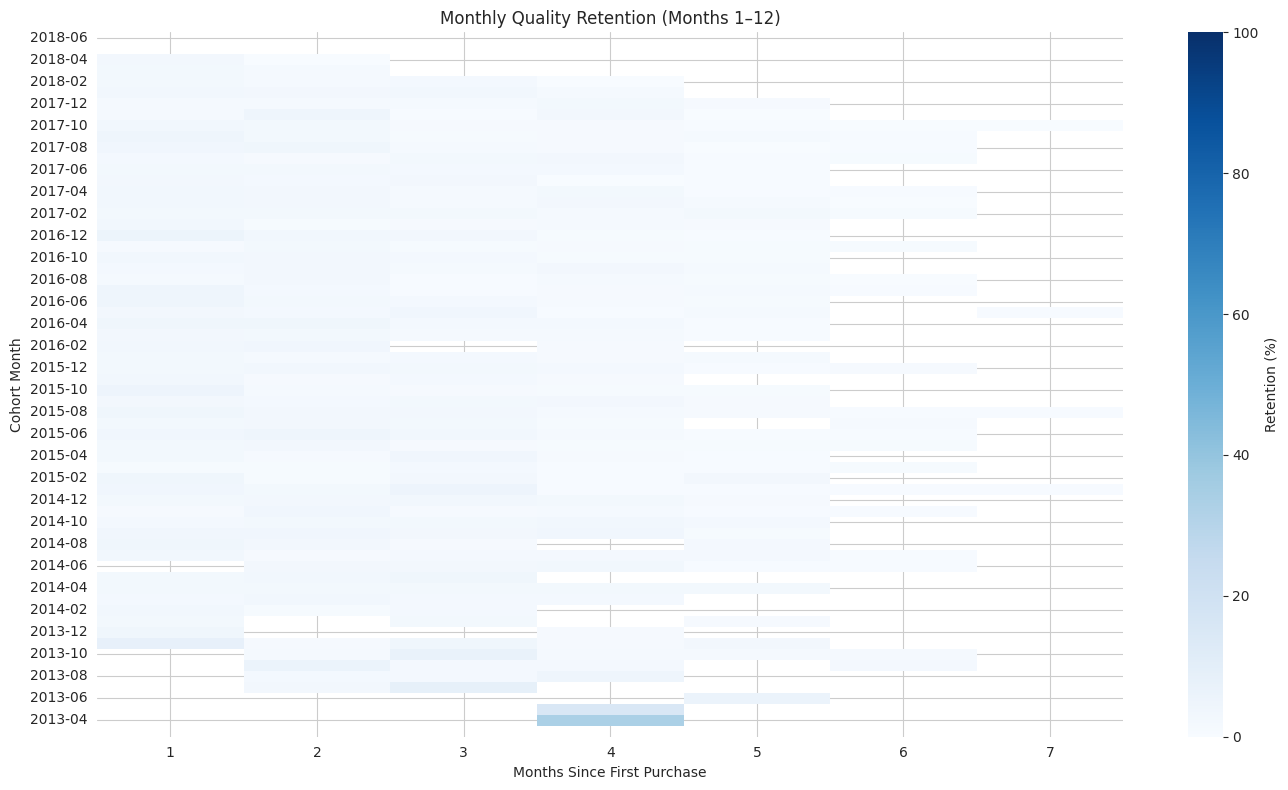

In [ ]:
# Quality Retention heatmap
quality_retention_pct.index = (
    quality_retention_pct.index
    .strftime("%Y-%m")
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    quality_retention_pct,
    cmap="Blues",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"label": "Retention (%)"},
    linewidths=0
)

plt.title("Monthly Quality Retention (Months 1–12)")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.tight_layout()
plt.show()

## Resurrection Analysis

A customer is considered *resurrected* if they make a purchase after being inactive
for at least **two consecutive months**. Inactivity is defined as having no completed
orders in a given month.

Resurrection rates measure the proportion of previously inactive customers who return
in a given month, relative to the population considered “lost” at that point in time.

In [ ]:
# Customer–Month Activity Grid
customer_month_grid_df = con.execute("""
WITH expanded_months AS (
    SELECT
        user_id,
        cohort_month,
        UNNEST(
            generate_series(
                cohort_month,
                cohort_month + INTERVAL '12 months',
                INTERVAL '1 month'
            )
        ) AS order_month
    FROM customer_cohorts
),
activity_flag AS (
    SELECT
        em.user_id,
        em.cohort_month,
        em.order_month,
        ca.user_id IS NOT NULL AS is_active
    FROM expanded_months em
    LEFT JOIN cohort_activity ca
      ON em.user_id = ca.user_id
     AND em.order_month = ca.order_month
)
SELECT
    user_id,
    cohort_month,
    order_month,
    is_active,
    DATE_DIFF('month', cohort_month, order_month) AS cohort_age
FROM activity_flag
WHERE DATE_DIFF('month', cohort_month, order_month) BETWEEN 0 AND 12
ORDER BY user_id, order_month
""").df()

customer_month_grid_df.head()

,user_id,cohort_month,order_month,is_active,cohort_age
0,17,2013-05-01,2013-05-01,True,0
1,17,2013-05-01,2013-06-01,False,1
2,17,2013-05-01,2013-07-01,False,2
3,17,2013-05-01,2013-08-01,False,3
4,17,2013-05-01,2013-09-01,False,4


In [ ]:
# Ensure correct ordering for temporal logic
customer_month_grid_df = customer_month_grid_df.sort_values(
    ["user_id", "order_month"]
)

# Inactivity flag
customer_month_grid_df["inactive"] = ~customer_month_grid_df["is_active"]

# Inactivity streak (consecutive inactive months)
customer_month_grid_df["inactive_streak"] = (
    customer_month_grid_df
    .groupby("user_id")["inactive"]
    .transform(
        lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1
    )
)

# Reset streak to 0 for active months
customer_month_grid_df.loc[
    customer_month_grid_df["is_active"], "inactive_streak"
] = 0

In [ ]:
# Resurrection event: Active month following >=2 inactive months
customer_month_grid_df["is_resurrected"] = (
    customer_month_grid_df["is_active"]
    & (customer_month_grid_df.groupby("user_id")["inactive_streak"].shift(1) >= 2)
)

# Fill NaN values (introduced by .shift()) with False
customer_month_grid_df["is_resurrected"] = (
    customer_month_grid_df["is_resurrected"].fillna(False)
)

In [ ]:
# Sanity check: Ressurrected customers should have a 0 inactivity streak
customer_month_grid_df[
    customer_month_grid_df["is_resurrected"]
][["user_id", "order_month", "inactive_streak"]].head()

,user_id,order_month,inactive_streak
602,694,2013-08-01,0
875,1009,2013-09-01,0
966,1078,2013-09-01,0
1526,1622,2013-11-01,0
2486,2950,2013-10-01,0


In [ ]:
# Aggregate Resurrection Rates by Cohort
con.register("customer_month_grid", customer_month_grid_df)

lost_customers_df = con.execute("""
SELECT
    cohort_month,
    cohort_age,
    COUNT(DISTINCT user_id) AS lost_customers
FROM customer_month_grid
WHERE inactive_streak >= 2
GROUP BY cohort_month, cohort_age
""").df()

In [ ]:
# Resurrection Events
resurrection_df = con.execute("""
SELECT
    cohort_month,
    cohort_age,
    COUNT(DISTINCT user_id) AS resurrected_customers
FROM customer_month_grid
WHERE is_resurrected
GROUP BY cohort_month, cohort_age
""").df()

In [ ]:
# Resurrection Table
resurrection_rate_df = lost_customers_df.merge(
    resurrection_df,
    on=["cohort_month", "cohort_age"],
    how="left"
)

resurrection_rate_df["resurrected_customers"] = (
    resurrection_rate_df["resurrected_customers"].fillna(0)
)

resurrection_rate_df["resurrection_rate"] = (
    resurrection_rate_df["resurrected_customers"] /
    resurrection_rate_df["lost_customers"]
).round(3)

In [ ]:
# Sanity Checks
assert (resurrection_rate_df["resurrection_rate"] <= 1.0).all()
assert (resurrection_rate_df["resurrection_rate"] >= 0).all()

In [ ]:
# Resurrection Matrix
resurrection_pivot = (
    resurrection_rate_df
    .pivot(index="cohort_month", columns="cohort_age", values="resurrection_rate")
    .sort_index()
)

In [ ]:
# Final Resurrection Rate Table
resurrection_rate_pct_df = resurrection_rate_df.assign(
    resurrection_pct=lambda df: df["resurrection_rate"] * 100
)

resurrection_rate_pct_df[["cohort_month", "cohort_age", "resurrection_pct"]].round(1).head()

,cohort_month,cohort_age,resurrection_pct
0,2016-06-01,9,0.0
1,2016-06-01,10,0.0
2,2016-06-01,11,0.0
3,2016-09-01,5,0.9
4,2016-09-01,10,0.0


Note: A line chart is used for resurrection behavior rather than a heatmap, as resurrection
events are relatively sparse and trends over time are more clearly communicated in aggregate.

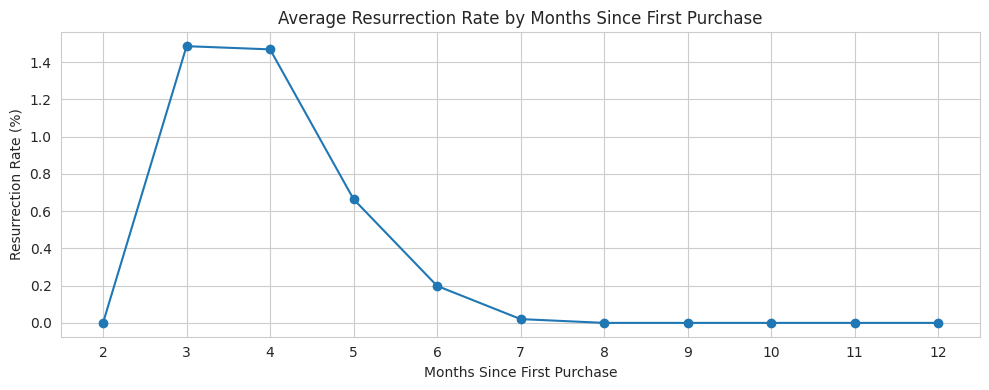

In [ ]:
# Average resurrection rate by cohort age (percent scale)
avg_resurrection_pct = (
    resurrection_rate_df
    .groupby("cohort_age")["resurrection_rate"]
    .mean() * 100
)

plt.figure(figsize=(10, 4))
avg_resurrection_pct.plot(marker="o")

plt.title("Average Resurrection Rate by Months Since First Purchase")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Resurrection Rate (%)")

plt.xticks(avg_resurrection_pct.index)

plt.grid(True)
plt.tight_layout()
plt.show()

## Key Findings

- **Overall retention is low across cohorts**, with standard retention dropping sharply after the first purchase. Even after excluding low-value single-purchase customers, quality-adjusted retention peaks at ~40% in the first cohort and dropping significantly afterwords, indicating that long-term retention remains a core growth challenge.

- **Early churn is driven largely by low-intent customers.**
  Quality retention is consistently higher than standard retention, especially in the first few months, suggesting that acquisition channels are attracting a meaningful share of customers unlikely to re-engage.

- **Resurrection rates are small but meaningful**, peaking around 1.5% and declining rapidly with time. This pattern is consistent with typical consumer behavior, where most churn is permanent.

- **Win-back efforts are most effective early.**
  Customers who return tend to do so within 2–4 months of inactivity, implying diminishing returns for late-stage reactivation campaigns. From a business perspective, this supports prioritizing time-bound win-back initiatives and allocating retention resources toward recently churned, higher-probability customers.

# Question 2: Customer Lifetime Value & Acquisition Efficiency

The retention and resurrection analysis shows that not all customers contribute equally to long-term growth. To translate these insights into actionable acquisition strategy, the next step is to estimate Customer Lifetime Value (CLV) by behavioral segment and derive data-driven Customer Acquisition Cost (CAC) thresholds for each segment.

## Customer Segmentation & CLV Framework

CLV is estimated at the segment level rather than per individual customer. Customers are first segmented based on their behavior in the **first 90 days after acquisition** (early behavior is a strong predictor of long-term value).

This approach enables explainable CLV estimates and actionable acquisition strategy by customer type.

In [ ]:
# First Purchase Timestamp
customer_first_purchase_df = con.execute("""
SELECT
    user_id,
    MIN(paid_at) AS first_purchase_ts
FROM orders
GROUP BY user_id
""").df()

In [ ]:
# Orders With Lifecycle Flags
orders_with_lifecycle_df = orders_df.merge(
    customer_first_purchase_df,
    on="user_id",
    how="left"
)

orders_with_lifecycle_df["days_since_first_purchase"] = (
    orders_with_lifecycle_df["paid_at"] - orders_with_lifecycle_df["first_purchase_ts"]
).dt.days

# Sanity check
orders_with_lifecycle_df[
    ["user_id", "paid_at", "first_purchase_ts", "days_since_first_purchase"]
].head()

,user_id,paid_at,first_purchase_ts,days_since_first_purchase
0,178481,2017-06-27 21:19:39+00:00,2017-06-27 21:19:39+00:00,0
1,178481,2017-06-27 21:19:39+00:00,2017-06-27 21:19:39+00:00,0
2,178481,2017-06-27 21:19:39+00:00,2017-06-27 21:19:39+00:00,0
3,154133,2016-10-07 10:08:10+00:00,2016-10-07 10:08:10+00:00,0
4,154133,2016-10-07 10:08:10+00:00,2016-10-07 10:08:10+00:00,0


**Sanity check:**  
This preview verifies that the lifecycle anchor is correct. Orders occurring on a customer’s first purchase date should have `days_since_first_purchase = 0`.
Multiple rows with zero values are expected because the dataset is at the line-item level (multiple items per invoice).

In [ ]:
# 90-Day Customer Summary
customer_90d_df = (
    orders_with_lifecycle_df
    [orders_with_lifecycle_df["days_since_first_purchase"] <= 90]
    .groupby("user_id")
    .agg(
        orders_90d=("invoice_id", "nunique"),
        revenue_90d=("price", "sum"),
        first_purchase_ts=("first_purchase_ts", "first")
    )
    .reset_index()
)

customer_90d_df.head()

,user_id,orders_90d,revenue_90d,first_purchase_ts
0,17,1,243.00,2013-05-25 08:27:17+00:00
1,25,1,1.80,2013-05-17 03:11:48+00:00
2,63,1,585.00,2013-07-07 11:26:45+00:00
3,65,1,44.50,2013-05-09 10:22:58+00:00
4,69,1,9.42,2013-08-09 23:25:51+00:00


In [ ]:
# Lifetime Customer Metrics
customer_lifetime_df = (
    orders_df
    .groupby("user_id")
    .agg(
        lifetime_orders=("invoice_id", "nunique"),
        lifetime_revenue=("price", "sum"),
        last_purchase_ts=("paid_at", "max")
    )
    .reset_index()
)

In [ ]:
# Unified Customer Table: 90-Day + Lifetime Views
customer_clv_base_df = customer_90d_df.merge(
    customer_lifetime_df,
    on="user_id",
    how="left"
)

customer_clv_base_df.head()

,user_id,orders_90d,revenue_90d,first_purchase_ts,lifetime_orders,lifetime_revenue,last_purchase_ts
0,17,1,243.00,2013-05-25 08:27:17+00:00,1,243.00,2013-05-25 08:27:17+00:00
1,25,1,1.80,2013-05-17 03:11:48+00:00,1,1.80,2013-05-17 03:11:48+00:00
2,63,1,585.00,2013-07-07 11:26:45+00:00,1,585.00,2013-07-07 11:26:45+00:00
3,65,1,44.50,2013-05-09 10:22:58+00:00,1,44.50,2013-05-09 10:22:58+00:00
4,69,1,9.42,2013-08-09 23:25:51+00:00,1,9.42,2013-08-09 23:25:51+00:00


In [ ]:
# Derived Core Metrics
customer_clv_base_df["aov_90d"] = (
    customer_clv_base_df["revenue_90d"] /
    customer_clv_base_df["orders_90d"]
)

customer_clv_base_df["purchase_frequency_90d"] = (
    customer_clv_base_df["orders_90d"] / 3  # orders per month
)

Customers are segmented along two dimensions based on their behavior in the first 90 days after acquisition:

- **Purchase behavior** distinguishes between single-purchase and repeat-purchase customers, as early repeat purchasing is a strong indicator of long-term engagement.

- **Value segment** is defined using the median 90-day revenue as a threshold. The median is used to create a balanced, data-driven split that avoids arbitrary cutoffs and adapts naturally to the revenue distribution.

This approach yields simple, explainable segments that are stable enough for CLV estimation and directly actionable for acquisition and onboarding strategy.

In [ ]:
# Customer Segment Definitions
# Purchase behavior
customer_clv_base_df["purchase_segment"] = np.where(
    customer_clv_base_df["orders_90d"] == 1,
    "single_purchaser",
    "repeat_purchaser"
)

# Value threshold: median 90-day revenue
value_threshold = customer_clv_base_df["revenue_90d"].median()

customer_clv_base_df["value_segment"] = np.where(
    customer_clv_base_df["revenue_90d"] >= value_threshold,
    "high_value",
    "low_value"
)

In [ ]:
# Final Customer Segmentation Table
customer_clv_base_df["clv_segment"] = (
    customer_clv_base_df["purchase_segment"] + " | " +
    customer_clv_base_df["value_segment"]
)

customer_clv_base_df["clv_segment"].value_counts()

,count
clv_segment,
single_purchaser | low_value,8548
single_purchaser | high_value,7912
repeat_purchaser | high_value,820
repeat_purchaser | low_value,183


In [ ]:
# Every customer must have at least one order in first 90 days
assert customer_clv_base_df["orders_90d"].ge(1).all()

The majority of customers fall into single-purchase segments, which is typical for consumer-facing products. Repeat purchasers represent a smaller share of the user base but are expected to contribute disproportionately to long-term value, making them a key focus for CLV estimation and acquisition efficiency.

## CLV Estimation Methodology

CLV is estimated at the segment level using a simple, explainable model:
- Average Order Value (AOV)
- Purchase frequency (orders per month)
- Estimated customer lifespan (in months)

In [ ]:
# Segment-Level Behavior
segment_metrics_df = (
    customer_clv_base_df
    .groupby("clv_segment")
    .agg(
        avg_aov=("aov_90d", "mean"),
        avg_purchase_frequency=("purchase_frequency_90d", "mean"),
        customers=("user_id", "count")
    )
    .reset_index()
)

segment_metrics_df

,clv_segment,avg_aov,avg_purchase_frequency,customers
0,repeat_purchaser | high_value,295.774407,0.678862,820
1,repeat_purchaser | low_value,34.105487,0.673953,183
2,single_purchaser | high_value,479.965307,0.333333,7912
3,single_purchaser | low_value,46.513265,0.333333,8548


We estimate lifespan using observed behavior:

`Lifespan = time between first and last purchase`
(only for customers with sufficient history)

In [ ]:
# Normalize timestamps to timezone-naive (only where columns exist)
customer_lifetime_df["last_purchase_ts"] = (
    pd.to_datetime(customer_lifetime_df["last_purchase_ts"])
    .dt.tz_localize(None)
)

customer_clv_base_df["first_purchase_ts"] = (
    pd.to_datetime(customer_clv_base_df["first_purchase_ts"])
    .dt.tz_localize(None)
)

# Merge first_purchase_ts into lifetime table
customer_lifetime_df = customer_lifetime_df.merge(
    customer_clv_base_df[["user_id", "first_purchase_ts"]],
    on="user_id",
    how="left"
)

# Calculate customer lifespan in months using 30-day periods for CLV estimation
customer_lifetime_df["lifespan_months"] = (
    (customer_lifetime_df["last_purchase_ts"] -
     customer_lifetime_df["first_purchase_ts"])
    .dt.days / 30
)

In [ ]:
# Every customer should have a first purchase timestamp
assert customer_lifetime_df["first_purchase_ts"].notna().all()

To estimate average customer lifespan for CLV modeling, customers with less than three months between first and last purchase are excluded. This filters out extremely short-lived or single-transaction customers whose observed lifespan is not yet informative. I used a three-month minimum to keep the lifecycle modeling consistent with the 90-day segmentation period.

Estimated lifespan is then derived at the segment level, using the average observed lifespan of similar customers (defined by early purchase behavior and value). This results in more stable and representative lifespan estimates for CLV calculation.

In [ ]:
# Filter to customers with meaningful history
lifespan_df = customer_lifetime_df[
    customer_lifetime_df["lifespan_months"] >= 3
]

# Aggregate by segment
lifespan_by_segment_df = (
    lifespan_df
    .merge(
        customer_clv_base_df[["user_id", "clv_segment"]],
        on="user_id",
        how="left"
    )
    .groupby("clv_segment")
    .agg(
        avg_lifespan_months=("lifespan_months", "mean")
    )
    .reset_index()
)

**CLV formula**: `CLV = AOV x Purchase Frequency x Lifespan (months)`

In [ ]:
# CLV Calculation
clv_df = (
    segment_metrics_df
    .merge(lifespan_by_segment_df, on="clv_segment", how="left")
)

clv_df["predicted_clv"] = (
    clv_df["avg_aov"] *
    clv_df["avg_purchase_frequency"] *
    clv_df["avg_lifespan_months"]
)

clv_df.round(2)

,clv_segment,avg_aov,avg_purchase_frequency,customers,avg_lifespan_months,predicted_clv
0,repeat_purchaser | high_value,295.77,0.68,820,3.90,782.38
1,repeat_purchaser | low_value,34.11,0.67,183,3.60,82.75
2,single_purchaser | high_value,479.97,0.33,7912,4.22,674.55
3,single_purchaser | low_value,46.51,0.33,8548,4.23,65.61


CLV estimates vary substantially across segments. Repeat purchasers represent a small share of customers but exhibit the highest predicted CLV, reflecting both higher purchase frequency and sustained engagement.

Single-purchase, high-value customers also contribute meaningful lifetime value due to large initial order sizes, highlighting the importance of differentiating acquisition strategy beyond simple repeat behavior.

## Acquisition ROI & CAC Thresholds

Maximum allowable Customer Acquisition Cost (CAC) is derived using a 3:1 LTV:CAC ratio, a common benchmark for sustainable growth in consumer and subscription-based products. This ensures acquisition spend remains profitable while allowing room for operating costs, retention investment, and margin.

In [ ]:
# CAC Thresholds (assuming 3:1 LTV:CAC ratio)
clv_df["max_cac"] = clv_df["predicted_clv"] / 3

In [ ]:
# Final CLV & CAC Table
clv_output_df = clv_df[[
    "clv_segment",
    "customers",
    "avg_aov",
    "avg_purchase_frequency",
    "avg_lifespan_months",
    "predicted_clv",
    "max_cac"
]].round(2)

clv_output_df

,clv_segment,customers,avg_aov,avg_purchase_frequency,avg_lifespan_months,predicted_clv,max_cac
0,repeat_purchaser | high_value,820,295.77,0.68,3.90,782.38,260.79
1,repeat_purchaser | low_value,183,34.11,0.67,3.60,82.75,27.58
2,single_purchaser | high_value,7912,479.97,0.33,4.22,674.55,224.85
3,single_purchaser | low_value,8548,46.51,0.33,4.23,65.61,21.87


CAC thresholds vary substantially across segments. High-value segments support
meaningfully higher acquisition costs, while low-value segments require strict
CAC discipline to remain profitable.

This highlights the importance of segment-aware acquisition strategy, where spend is optimized based on expected customer value rather than applied uniformly across all users.

## Validation

In [ ]:
# Build CLV validation base
actual_clv_df = (
    orders_df
    .groupby("user_id")
    .agg(
        first_purchase_ts=("paid_at", "min"),
        last_purchase_ts=("paid_at", "max"),
        lifetime_revenue=("price", "sum")
    )
    .reset_index()
    .merge(
        customer_clv_base_df[["user_id", "clv_segment"]],
        on="user_id",
        how="left"
    )
)

In [ ]:
# Normalize timestamps to timezone-naive for calendar-based lifecycle analysis
actual_clv_df["first_purchase_ts"] = (
    pd.to_datetime(actual_clv_df["first_purchase_ts"])
    .dt.tz_localize(None)
)

actual_clv_df["last_purchase_ts"] = (
    pd.to_datetime(actual_clv_df["last_purchase_ts"])
    .dt.tz_localize(None)
)

In [ ]:
# Approximate customer age in months using 30-day periods
actual_clv_df["customer_age_months"] = (
    (actual_clv_df["last_purchase_ts"] -
     actual_clv_df["first_purchase_ts"])
    .dt.days / 30
)

In [ ]:
# Customer age in months is >= 0
assert (actual_clv_df["customer_age_months"] >= 0).all()

In [ ]:
actual_clv_df["customer_age_months"].max()

6.566666666666666

The dataset does not contain customers with a full 12 months of observed purchase history. As a result, a direct comparison between predicted CLV and realized CLV over a 12-month window is not possible.

With longer customer histories, predicted CLV would be validated by comparing segment-level CLV estimates against realized lifetime revenue for customers with sufficient tenure.

Despite this limitation, the segment-level CLV estimates remain a clear and actionable framework for acquisition strategy and CAC decision-making.

# Question 3: Growth Decomposition & Revenue Health

Python is used in this section to model time-dependent customer behavior, including lagged revenue comparisons and explicit churn detection based on missing activity. This approach enables clear, stepwise growth decomposition and validation prior to executive-level interpretation.

## Growth Decomposition

Monthly revenue growth is decomposed into mutually exclusive components representing new customer acquisition, expansion and contraction among existing customers, and revenue loss due to churn. This breakdown enables total growth to be fully reconciled and attributed to its underlying drivers.

In [ ]:
# Normalize orders to customer-month grain
orders_df["order_month"] = orders_df["paid_at"].dt.to_period("M").dt.to_timestamp()

/tmp/ipython-input-3186365207.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  orders_df["order_month"] = orders_df["paid_at"].dt.to_period("M").dt.to_timestamp()


In [ ]:
# Aggregate to customer–month revenue
customer_month_revenue_df = (
    orders_df
    .groupby(["user_id", "order_month"])
    .agg(
        monthly_revenue=("price", "sum")
    )
    .reset_index()
)

customer_month_revenue_df.head()

,user_id,order_month,monthly_revenue
0,17,2013-05-01,243.00
1,25,2013-05-01,1.80
2,63,2013-07-01,585.00
3,65,2013-05-01,44.50
4,69,2013-08-01,9.42


In [ ]:
# Non-negative revenue check
assert (customer_month_revenue_df["monthly_revenue"] >= 0).all()

In [ ]:
# Monthly coverage
customer_month_revenue_df["order_month"].min(), customer_month_revenue_df["order_month"].max()

(Timestamp('2013-03-01 00:00:00'), Timestamp('2018-06-01 00:00:00'))

The dataset timespan is 5 years and 3 months. That means we have 63 months avaiable for growth analysis.

We define first purchase month as the earliest month in which a customer generated revenue.

In [ ]:
# First purchase month per customer
customer_first_month_df = (
    customer_month_revenue_df
    .groupby("user_id")
    .agg(
        first_purchase_month=("order_month", "min")
    )
    .reset_index()
)

In [ ]:
# Enrich customer–month table
customer_month_revenue_df = customer_month_revenue_df.merge(
    customer_first_month_df,
    on="user_id",
    how="left"
)

# New customer flag
customer_month_revenue_df["is_new_customer"] = (
    customer_month_revenue_df["order_month"]
    == customer_month_revenue_df["first_purchase_month"]
)

A customer is classified as “new” in the month of their first recorded purchase.
All subsequent months are treated as existing-customer activity. This distinction enables revenue growth to be decomposed cleanly into acquisition-driven and existing-customer–driven components.

In [ ]:
# Every customer can only be “new” once
assert (
    customer_month_revenue_df
    .groupby("user_id")["is_new_customer"]
    .sum()
    .eq(1)
).all()

To detect expansion, contraction, and churn, we need to compare each customer’s revenue to their own prior month.

In [ ]:
# Sort for month-over-month calculations
customer_month_revenue_df = customer_month_revenue_df.sort_values(
    ["user_id", "order_month"]
)

# Previous month revenue per customer
customer_month_revenue_df["prev_month_revenue"] = (
    customer_month_revenue_df
    .groupby("user_id")["monthly_revenue"]
    .shift(1)
)

# Compute month-over-month revenue delta
customer_month_revenue_df["revenue_delta"] = (
    customer_month_revenue_df["monthly_revenue"]
    - customer_month_revenue_df["prev_month_revenue"]
)

In [ ]:
# Validate delta arithmetic
delta_check = (
    customer_month_revenue_df["monthly_revenue"]
    - customer_month_revenue_df["prev_month_revenue"]
)

assert customer_month_revenue_df["revenue_delta"].equals(delta_check)

A customer is considered churned in month M if:
- they had revenue in M−1
- they have zero revenue in M

Because we only store rows where revenue exists, churn must be inferred.

In [ ]:
# Churn: customer had revenue in previous month but none in current month
customer_month_revenue_df["is_churned"] = (
    (customer_month_revenue_df["prev_month_revenue"].notna()) &
    (customer_month_revenue_df["monthly_revenue"] == 0)
)

Right now we have a table that only contains months where a customer had revenue. That means:

- churned months do not exist as rows
- churn revenue cannot be measured
- contraction vs churn cannot be separated cleanly

A complete customer–month grid is constructed to explicitly represent months with zero revenue. This allows churn to be identified as revenue loss from customers who were active in the prior month but generated no revenue in the current month, enabling clean separation of churn from contraction.

In [ ]:
# Global month range
month_range = pd.date_range(
    start=customer_month_revenue_df["order_month"].min(),
    end=customer_month_revenue_df["order_month"].max(),
    freq="MS"  # month start
)

# Customer-month grid
customer_month_grid_df = (
    pd.MultiIndex.from_product(
        [
            customer_month_revenue_df["user_id"].unique(),
            month_range
        ],
        names=["user_id", "order_month"]
    )
    .to_frame(index=False)
)

In [ ]:
# Merge revenue onto grid
customer_month_grid_df = customer_month_grid_df.merge(
    customer_month_revenue_df,
    on=["user_id", "order_month"],
    how="left"
)

# Fill missing revenue with zero
customer_month_grid_df["monthly_revenue"] = (
    customer_month_grid_df["monthly_revenue"]
    .fillna(0)
)

Zero revenue now explicitly represents churn or inactivity.

In [ ]:
# Sort for correct lag calculation
customer_month_grid_df = customer_month_grid_df.sort_values(
    ["user_id", "order_month"]
)

customer_month_grid_df["prev_month_revenue"] = (
    customer_month_grid_df
    .groupby("user_id")["monthly_revenue"]
    .shift(1)
)

customer_month_grid_df["revenue_delta"] = (
    customer_month_grid_df["monthly_revenue"]
    - customer_month_grid_df["prev_month_revenue"]
)

In [ ]:
# Define churn flag
customer_month_grid_df["is_churned"] = (
    (customer_month_grid_df["prev_month_revenue"] > 0) &
    (customer_month_grid_df["monthly_revenue"] == 0)
)

# Define churned revenue
customer_month_grid_df["churned_revenue"] = np.where(
    customer_month_grid_df["is_churned"],
    customer_month_grid_df["prev_month_revenue"],
    0
)

In [ ]:
# No negative revenue invariant
assert (customer_month_grid_df["monthly_revenue"] >= 0).all()

In [ ]:
# Preview churn cases
customer_month_grid_df[
    customer_month_grid_df["is_churned"]
][
    ["user_id", "order_month", "prev_month_revenue", "monthly_revenue", "churned_revenue"]
].head()

,user_id,order_month,prev_month_revenue,monthly_revenue,churned_revenue
3,17,2013-06-01,243.00,0.0,243.00
67,25,2013-06-01,1.80,0.0,1.80
133,63,2013-08-01,585.00,0.0,585.00
195,65,2013-06-01,44.50,0.0,44.50
262,69,2013-09-01,9.42,0.0,9.42


You should see:
- previous revenue > 0
- current revenue = 0
- churned revenue equal to prior month revenue

We now have to decompose month-over-month revenue change for each customer–month into:

- **New customer revenue**: Revenue where `is_new_customer = True`
- **Expansion revenue**: Existing customers where `revenue_delta > 0`
- **Contraction revenue**: Existing customers where `revenue_delta < 0` and still active
- **Churn impact**: Customers where `is_churned = True` (entire prior-month revenue is lost)

In [ ]:
# New customer revenue
customer_month_grid_df["new_customer_revenue"] = np.where(
    customer_month_grid_df["is_new_customer"],
    customer_month_grid_df["monthly_revenue"],
    0
)

# Ensure 'is_new_customer' is boolean for unary ~ operator
customer_month_grid_df["is_new_customer"] = \
    customer_month_grid_df["is_new_customer"] \
    .fillna(False) \
    .astype(bool)

# Expansion revenue (existing customers only)
customer_month_grid_df["expansion_revenue"] = np.where(
    (customer_month_grid_df["revenue_delta"] > 0) &
    (~customer_month_grid_df["is_new_customer"]),
    customer_month_grid_df["revenue_delta"],
    0
)

# Contraction revenue (existing customers only, still active)
customer_month_grid_df["contraction_revenue"] = np.where(
    (customer_month_grid_df["revenue_delta"] < 0) &
    (customer_month_grid_df["monthly_revenue"] > 0),
    customer_month_grid_df["revenue_delta"],
    0
)

/tmp/ipython-input-599499534.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False) \


In [ ]:
# Monthly growth decomposition table
monthly_growth_df = (
    customer_month_grid_df
    .groupby("order_month")
    .agg(
        total_revenue=("monthly_revenue", "sum"),
        new_customer_revenue=("new_customer_revenue", "sum"),
        expansion_revenue=("expansion_revenue", "sum"),
        contraction_revenue=("contraction_revenue", "sum"),
        churned_revenue=("churned_revenue", "sum")
    )
    .reset_index()
)

In [ ]:
# Month-over-month revenue change
monthly_growth_df = monthly_growth_df.sort_values("order_month")

monthly_growth_df["prev_total_revenue"] = (
    monthly_growth_df["total_revenue"].shift(1)
)

monthly_growth_df["net_revenue_change"] = (
    monthly_growth_df["total_revenue"]
    - monthly_growth_df["prev_total_revenue"]
)

In [ ]:
monthly_growth_df["reconciled_change"] = (
    monthly_growth_df["new_customer_revenue"]
    + monthly_growth_df["expansion_revenue"]
    + monthly_growth_df["contraction_revenue"]
    - monthly_growth_df["churned_revenue"]
)

# Sanity check: verify that monthly growth components fully reconcile to total revenue change
recon_diff = (
    monthly_growth_df["net_revenue_change"]
    - monthly_growth_df["reconciled_change"]
).fillna(0)

assert np.isclose(recon_diff, 0).all()

Monthly revenue growth is decomposed into mutually exclusive components that fully reconcile to total revenue change.

In [ ]:
monthly_growth_df[
    [
        "order_month",
        "new_customer_revenue",
        "expansion_revenue",
        "contraction_revenue",
        "churned_revenue",
        "net_revenue_change"
    ]
].head()

,order_month,new_customer_revenue,expansion_revenue,contraction_revenue,churned_revenue,net_revenue_change
0,2013-03-01,500.400,0.0,0.0,0.000,NaN
1,2013-04-01,436.970,0.0,0.0,500.400,-63.430
2,2013-05-01,3590.445,0.0,0.0,436.970,3153.475
3,2013-06-01,6476.530,0.0,0.0,3590.445,2886.085
4,2013-07-01,12776.715,0.0,0.0,6476.530,6300.185


## Net Revenue Retention (NRR)

Net Revenue Retention measures revenue growth from existing customers only, isolating the impact of expansion, contraction, and churn while excluding new customer acquisition.

In [ ]:
# NRR inputs per month
nrr_df = (
    customer_month_grid_df
    .loc[customer_month_grid_df["prev_month_revenue"] > 0]
    .groupby("order_month")
    .agg(
        beginning_revenue=("prev_month_revenue", "sum"),
        ending_revenue_existing=("monthly_revenue", "sum")
    )
    .reset_index()
)

# NRR calculation
nrr_df["nrr"] = (
    nrr_df["ending_revenue_existing"]
    / nrr_df["beginning_revenue"]
)

In [ ]:
# No negative values
assert (nrr_df["beginning_revenue"] >= 0).all()
assert (nrr_df["ending_revenue_existing"] >= 0).all()

In [ ]:
nrr_df[
    ["order_month", "beginning_revenue", "ending_revenue_existing", "nrr"]
].head()

,order_month,beginning_revenue,ending_revenue_existing,nrr
0,2013-04-01,500.400,0.0,0.0
1,2013-05-01,436.970,0.0,0.0
2,2013-06-01,3590.445,0.0,0.0
3,2013-07-01,6476.530,0.0,0.0
4,2013-08-01,12776.715,0.0,0.0


NRR values above 100% (1.0) indicate that expansion offsets contraction and churn, while values below 100% signal reliance on new customer acquisition to drive growth.

## Growth Sustainability

To assess whether revenue growth is sustainable, monthly growth is classified based on whether it is primarily driven by new customer acquisition or by net expansion within the existing customer base.

In [ ]:
# Growth driver attribution
monthly_growth_df["existing_customer_net"] = (
    monthly_growth_df["expansion_revenue"]
    + monthly_growth_df["contraction_revenue"]
    - monthly_growth_df["churned_revenue"]
)

monthly_growth_df["growth_driver"] = np.where(
    monthly_growth_df["new_customer_revenue"] >
    monthly_growth_df["existing_customer_net"],
    "Acquisition-led",
    "Expansion-led"
)

In [ ]:
# Monthly Growth table (first 5 rows)
monthly_growth_df[
    ["order_month", "new_customer_revenue", "existing_customer_net", "growth_driver"]
].head()

,order_month,new_customer_revenue,existing_customer_net,growth_driver
0,2013-03-01,500.400,0.000,Acquisition-led
1,2013-04-01,436.970,-500.400,Acquisition-led
2,2013-05-01,3590.445,-436.970,Acquisition-led
3,2013-06-01,6476.530,-3590.445,Acquisition-led
4,2013-07-01,12776.715,-6476.530,Acquisition-led


Months where growth is primarily acquisition-led may indicate reliance on continued customer acquisition, while expansion-led months suggest more sustainable growth driven by the existing customer base.

In [ ]:
waterfall_df = monthly_growth_df.melt(
    id_vars=["order_month"],
    value_vars=[
        "new_customer_revenue",
        "expansion_revenue",
        "contraction_revenue",
        "churned_revenue"
    ],
    var_name="component",
    value_name="revenue_change"
)

# Make churn negative for waterfall visualization
waterfall_df["revenue_change"] = np.where(
    waterfall_df["component"] == "churned_revenue",
    -waterfall_df["revenue_change"],
    waterfall_df["revenue_change"]
)

To assess overall growth sustainability, monthly growth components are aggregated across the observed period and visualized as a single waterfall. While growth is calculated at a monthly level, aggregating components highlights the dominant drivers of revenue change over time and avoids noise from month-to-month volatility.

In [ ]:
# Aggregate components across months
component_order = [
    "new_customer_revenue",
    "expansion_revenue",
    "contraction_revenue",
    "churned_revenue"
]

waterfall_plot_df = (
    waterfall_df
    .groupby("component", as_index=False)
    .agg(total_revenue_change=("revenue_change", "sum"))
)

waterfall_plot_df["component"] = pd.Categorical(
    waterfall_plot_df["component"],
    categories=component_order,
    ordered=True
)

waterfall_plot_df = waterfall_plot_df.sort_values("component")

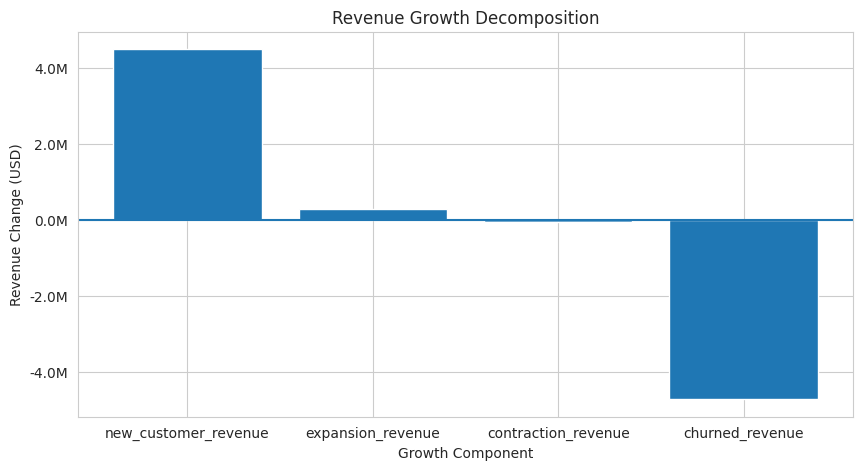

In [ ]:
# Growth waterfall
plt.figure(figsize=(10, 5))
plt.bar(
    waterfall_plot_df["component"],
    waterfall_plot_df["total_revenue_change"]
)
plt.title("Revenue Growth Decomposition")
plt.xlabel("Growth Component")
plt.ylabel("Revenue Change (USD)")

plt.axhline(0)
plt.gca().yaxis.set_major_formatter(
    lambda x, pos: f"{x/1e6:.1f}M"
)

plt.show()

The growth decomposition shows that revenue growth is driven primarily by new customer acquisition, while churn represents a substantial offset to overall growth. Existing-customer expansion contributes positively but is relatively small compared to both new customer revenue and churn.

This pattern indicates that growth is currently acquisition-led, with sustainability dependent on maintaining efficient acquisition while reducing churn over time.

# Question 4: Customer Risk Scoring & Churn Prevention

## Risk Score Calculation


### Feature Engineering for Customer Risk Scoring

To proactively identify customers at risk of churn, we first construct a set of
customer-level behavioral features that capture recent activity, engagement depth, and spending dynamics. These features form the foundation of an explainable risk scoring framework aligned with how Customer Success teams reason about customer health.

In [ ]:
# Reference date for recency calculations (end of dataset)
analysis_date = orders_df["paid_at"].max()

# Customer-level base table
customer_base_df = (
    orders_df
    .groupby("user_id")
    .agg(
        last_purchase_date=("paid_at", "max"),
        first_purchase_date=("paid_at", "min"),
        total_orders=("invoice_id", "nunique"),
        total_revenue=("price", "sum"),
        avg_order_value=("price", "mean")
    )
    .reset_index()
)

**Recency** is typically the strongest churn signal. Customers who have not purchased recently are significantly more likely to churn, regardless of historical value.

In [ ]:
# Calculate days since last purchase
customer_base_df["days_since_last_purchase"] = (
    analysis_date - customer_base_df["last_purchase_date"]
).dt.days

**Frequency trend** captures whether a customer’s purchasing behavior is accelerating or declining. A drop in recent purchase cadence often signals early disengagement before full churn.

In [ ]:
# Orders in last 90 days
orders_90d_df = orders_df[
    orders_df["paid_at"] >= (analysis_date - pd.Timedelta(days=90))
]

orders_90d_counts = (
    orders_90d_df
    .groupby("user_id")
    .agg(orders_last_90d=("invoice_id", "nunique"))
    .reset_index()
)

customer_base_df = customer_base_df.merge(
    orders_90d_counts,
    on="user_id",
    how="left"
)

customer_base_df["orders_last_90d"] = (
    customer_base_df["orders_last_90d"].fillna(0)
)

# Frequency trend ratio
customer_base_df["frequency_trend"] = (
    customer_base_df["orders_last_90d"] /
    customer_base_df["total_orders"]
)

**Monetary trend** captures changes in customer spending behavior. Declining recent spend relative to historical levels may indicate weakening customer commitment.

In [ ]:
# Calculate monetary trend
revenue_90d_df = (
    orders_90d_df
    .groupby("user_id")
    .agg(revenue_last_90d=("price", "sum"))
    .reset_index()
)

customer_base_df = customer_base_df.merge(
    revenue_90d_df,
    on="user_id",
    how="left"
)

customer_base_df["revenue_last_90d"] = (
    customer_base_df["revenue_last_90d"].fillna(0)
)

customer_base_df["monetary_trend"] = (
    customer_base_df["revenue_last_90d"] /
    customer_base_df["total_revenue"]
)

**Engagement** reflects how deeply a customer interacts with the product offering. Customers purchasing across multiple categories or maintaining stable order sizes tend to be more resilient to churn.

In [ ]:
engagement_df = (
    orders_df
    .groupby("user_id")
    .agg(
        category_diversity=("item_category", "nunique"),
        order_value_std=("price", "std")
    )
    .reset_index()
)

customer_base_df = customer_base_df.merge(
    engagement_df,
    on="user_id",
    how="left"
)

customer_base_df["order_value_std"] = (
    customer_base_df["order_value_std"].fillna(0)
)

Before constructing the risk score, we validate that all engineered features are
well-formed, non-negative where expected, and interpretable at a customer level.

In [ ]:
customer_base_df[[
    "days_since_last_purchase",
    "frequency_trend",
    "monetary_trend",
    "category_diversity",
    "order_value_std"
]].describe()

,days_since_last_purchase,frequency_trend,monetary_trend,category_diversity,order_value_std
count,17463.000000,17463.000000,17169.000000,17463.000000,17463.000000
mean,688.399759,0.077798,0.077870,1.141957,55.128381
std,462.282023,0.265880,0.266892,0.466191,101.457558
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,292.000000,0.000000,0.000000,1.000000,0.506153
50%,628.000000,0.000000,0.000000,1.000000,16.793786
75%,1035.000000,0.000000,0.000000,1.000000,63.639610
max,1907.000000,1.000000,1.000000,8.000000,1590.990258


### Risk Score Construction

To combine heterogeneous behavioral signals into a single customer risk score,
features are normalized onto a comparable 0–1 scale and combined using a weighted sum. Higher scores indicate higher churn risk.

Weights are chosen heuristically for interpretability, with recency weighted most heavily due to its strong empirical relationship with churn, and remaining signals used to smooth false positives from any single dimension.

In [ ]:
# Recency risk (percentile-based)
customer_base_df["recency_risk"] = (
    customer_base_df["days_since_last_purchase"]
    .rank(pct=True)
)

In [ ]:
# Frequency risk (inverse of recent activity share)
customer_base_df["frequency_risk"] = 1 - customer_base_df["frequency_trend"]

In [ ]:
# Monetary risk (inverse of recent spend share)
customer_base_df["monetary_risk"] = 1 - customer_base_df["monetary_trend"]

In [ ]:
# Normalize engagement components
category_risk = 1 - customer_base_df["category_diversity"].rank(pct=True)
order_value_risk = customer_base_df["order_value_std"].rank(pct=True)

# Combined engagement risk
customer_base_df["engagement_risk"] = (
    0.5 * category_risk + 0.5 * order_value_risk
)

The composite risk score combines all four risk dimensions, with recency weighted most heavily due to its strong empirical relationship with churn.

Missing behavioral signals are assigned a neutral risk value to ensure all customers receive a comparable and interpretable risk score.

In [ ]:
# Handle missing risk components by assigning neutral risk (0.5)
risk_components = [
    "recency_risk",
    "frequency_risk",
    "monetary_risk",
    "engagement_risk"
]

customer_base_df[risk_components] = (
    customer_base_df[risk_components]
    .fillna(0.5)
)

In [ ]:
# Calculate risk score
customer_base_df["risk_score"] = (
    0.4 * customer_base_df["recency_risk"] +
    0.2 * customer_base_df["frequency_risk"] +
    0.2 * customer_base_df["monetary_risk"] +
    0.2 * customer_base_df["engagement_risk"]
)

Risk scores are expected to fall between 0 and 1, with higher values indicating
higher churn risk.

In [ ]:
customer_base_df["risk_score"].describe()

,risk_score
count,17463.000000
mean,0.667457
std,0.192034
min,0.040821
25%,0.598095
50%,0.698007
75%,0.798279
max,0.953233


In [ ]:
assert customer_base_df["risk_score"].between(0, 1).all()

The distribution below illustrates how churn risk is spread across the customer base and helps identify natural cutoffs for prioritization.

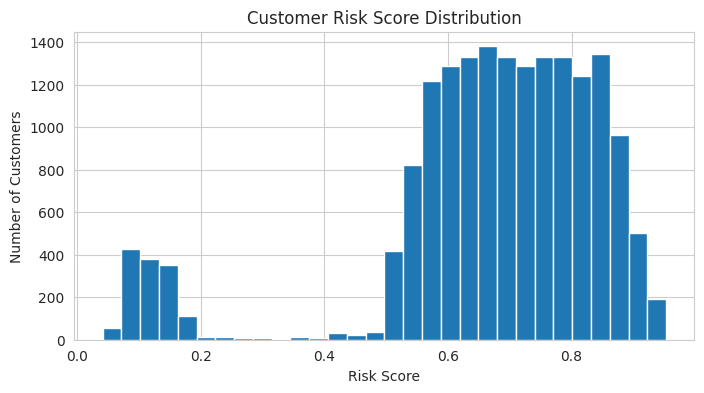

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(customer_base_df["risk_score"], bins=30)
plt.title("Customer Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Number of Customers")
plt.show()

The risk score distribution is bimodal, reflecting a small group of recently active, low-risk customers and a larger population of inactive or lapsed customers with elevated churn risk. This separation supports the use of risk thresholds to focus retention efforts on customers showing early warning signs rather than those who are already fully churned.

## Churn Probability Estimation for Inactive Customers

For customers who have been inactive for 30 or more days, we estimate the probability of return using observed historical behavior of similar customers.

Rather than fitting a machine learning model, churn probability is estimated using empirical return rates derived from historical behavior. This approach prioritizes interpretability and direct actionability for Customer Success teams, and avoids overfitting given limited labeled churn outcomes.

In [ ]:
# Identify inactive customers (30+ days)
inactive_customers_df = customer_base_df[
    customer_base_df["days_since_last_purchase"] >= 30
].copy()

Customers are bucketed by inactivity duration to capture how return likelihood
changes as inactivity length increases.

In [ ]:
inactive_customers_df["inactivity_bucket"] = pd.cut(
    inactive_customers_df["days_since_last_purchase"],
    bins=[30, 60, 90, 180, np.inf],
    labels=["30-60", "60-90", "90-180", "180+"]
)

In [ ]:
# Identify customers who returned after inactivity
orders_df = orders_df.sort_values(["user_id", "paid_at"])

orders_df["days_since_prev_purchase"] = (
    orders_df.groupby("user_id")["paid_at"].diff().dt.days
)

# A return event = gap >=30 days followed by a purchase
return_events_df = orders_df[
    orders_df["days_since_prev_purchase"] >= 30
][["user_id"]].drop_duplicates()

inactive_customers_df["has_returned"] = (
    inactive_customers_df["user_id"]
    .isin(return_events_df["user_id"])
)

Return probability is calculated as the historical share of customers in each
inactivity bucket who eventually return.

In [ ]:
return_rate_df = (
    inactive_customers_df
    .groupby("inactivity_bucket")
    .agg(
        customers=("user_id", "count"),
        returned=("has_returned", "sum")
    )
    .reset_index()
)

return_rate_df["return_probability"] = (
    return_rate_df["returned"] / return_rate_df["customers"]
)

return_rate_df

/tmp/ipython-input-2105740274.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("inactivity_bucket")


,inactivity_bucket,customers,returned,return_probability
0,30-60,477,28,0.058700
1,60-90,475,30,0.063158
2,90-180,1339,77,0.057506
3,180+,14711,874,0.059411


Churn probability is defined as one minus the probability of return for customers in the same inactivity bucket.

Customers without sufficient historical data to estimate return probability are
assigned a conservative high churn probability.

In [ ]:
inactive_customers_df = inactive_customers_df.merge(
    return_rate_df[["inactivity_bucket", "return_probability"]],
    on="inactivity_bucket",
    how="left"
)

inactive_customers_df["churn_probability"] = (
    1 - inactive_customers_df["return_probability"]
)

inactive_customers_df["churn_probability"] = (
    inactive_customers_df["churn_probability"]
    .fillna(1.0)
)

In [ ]:
assert inactive_customers_df["churn_probability"].between(0, 1).all()

In [ ]:
# Sanity check
inactive_customers_df[[
    "days_since_last_purchase",
    "inactivity_bucket",
    "return_probability",
    "churn_probability"
]].head()

,days_since_last_purchase,inactivity_bucket,return_probability,churn_probability
0,1836,180+,0.059411,0.940589
1,1844,180+,0.059411,0.940589
2,1793,180+,0.059411,0.940589
3,1852,180+,0.059411,0.940589
4,1759,180+,0.059411,0.940589


## Value-at-Risk & Retention Prioritization

To prioritize limited Customer Success resources, churn risk is combined with
expected customer value. This ensures retention efforts focus on customers who
are both likely to churn and represent meaningful potential value loss.

Predicted CLV is estimated at the segment level for stability and explainability. Customers inherit the predicted CLV of their corresponding behavioral segment.

In [ ]:
# Attach predicted CLV segment to inactive customers
inactive_customers_df = inactive_customers_df.merge(
    customer_clv_base_df[["user_id", "clv_segment"]],
    on="user_id",
    how="left"
)

# Attach predicted CLV
inactive_customers_df = inactive_customers_df.merge(
    clv_df[["clv_segment", "predicted_clv"]],
    on="clv_segment",
    how="left"
)

High-value customers are defined as the top 20% of customers by predicted CLV.
These customers represent disproportionate long-term value and are prioritized
for proactive retention when early churn signals are present.

High-value customers are identified relative to the inactive customer population, reflecting which inactive customers represent the greatest potential value loss if not retained.

In [ ]:
clv_80th_percentile = inactive_customers_df["predicted_clv"].quantile(0.80)

inactive_customers_df["is_high_value"] = (
    inactive_customers_df["predicted_clv"] >= clv_80th_percentile
)

In [ ]:
inactive_customers_df["is_high_value"].value_counts(normalize=True)

,proportion
is_high_value,
True,0.500206
False,0.499794


Value-at-risk represents the expected value loss if a customer churns, combining
predicted customer value with churn probability.

In [ ]:
inactive_customers_df["value_at_risk"] = (
    inactive_customers_df["predicted_clv"] *
    inactive_customers_df["churn_probability"]
)

## Action Prioritization

Customers are prioritized using a composite score that accounts for both churn
likelihood and potential value loss. Higher scores indicate higher urgency for
retention intervention.

In [ ]:
inactive_customers_df["priority_score"] = (
    inactive_customers_df["risk_score"] *
    inactive_customers_df["predicted_clv"]
)

In [ ]:
top_50_customers_df = (
    inactive_customers_df
    .sort_values("priority_score", ascending=False)
    .head(50)
)

top_50_customers_df[[
    "user_id",
    "days_since_last_purchase",
    "risk_score",
    "churn_probability",
    "predicted_clv",
    "value_at_risk",
    "priority_score"
]]

,user_id,days_since_last_purchase,risk_score,churn_probability,predicted_clv,value_at_risk,priority_score
465,6988,1631,0.909088,0.940589,782.37625,735.894241,711.248693
385,5831,1612,0.893801,0.940589,782.37625,735.894241,699.288815
797,12082,1602,0.892387,0.940589,782.37625,735.894241,698.182207
303,4453,1611,0.892152,0.940589,782.37625,735.894241,697.998519
313,4645,1651,0.891677,0.940589,782.37625,735.894241,697.626663
408,6171,1623,0.890537,0.940589,782.37625,735.894241,696.735105
191,2950,1689,0.889369,0.940589,782.37625,735.894241,695.821145
340,5067,1630,0.889020,0.940589,782.37625,735.894241,695.547853
532,8229,1615,0.888487,0.940589,782.37625,735.894241,695.131195
1733,27193,1445,0.887047,0.940589,782.37625,735.894241,694.004427


In [ ]:
assert top_50_customers_df.shape[0] == 50
assert top_50_customers_df["priority_score"].is_monotonic_decreasing

In [ ]:
top_50_customers_df.describe()

,user_id,total_orders,total_revenue,avg_order_value,days_since_last_purchase,orders_last_90d,frequency_trend,revenue_last_90d,monetary_trend,category_diversity,order_value_std,recency_risk,frequency_risk,monetary_risk,engagement_risk,risk_score,return_probability,churn_probability,predicted_clv,value_at_risk,priority_score
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.0,50.0,50.0,50.0,50.000000,50.000000,50.000000,50.0,50.0,50.000000,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000
mean,14685.720000,2.120000,920.51420,175.620563,1511.560000,0.0,0.0,0.0,0.0,2.060000,172.036586,0.940165,1.0,1.0,0.486548,0.873376,5.941132e-02,9.405887e-01,7.823763e+02,735.894241,683.308501
std,10446.048178,0.328261,630.50523,121.601806,142.966695,0.0,0.0,0.0,0.0,0.739829,139.905889,0.042349,0.0,0.0,0.075281,0.012763,1.401868e-17,2.242989e-16,3.445231e-13,0.000000,9.985077
min,849.000000,2.000000,158.00000,26.287500,1182.000000,0.0,0.0,0.0,0.0,1.000000,25.988153,0.823312,1.0,1.0,0.322267,0.853499,5.941132e-02,9.405887e-01,7.823763e+02,735.894241,667.757211
25%,6375.250000,2.000000,430.15000,84.195536,1428.250000,0.0,0.0,0.0,0.0,2.000000,73.547797,0.920596,1.0,1.0,0.440224,0.862121,5.941132e-02,9.405887e-01,7.823763e+02,735.894241,674.503263
50%,11678.500000,2.000000,794.20500,143.337500,1513.000000,0.0,0.0,0.0,0.0,2.000000,145.695018,0.947503,1.0,1.0,0.490551,0.874016,5.941132e-02,9.405887e-01,7.823763e+02,735.894241,683.809746
75%,22696.000000,2.000000,1228.76250,229.925000,1622.250000,0.0,0.0,0.0,0.0,2.000000,219.228715,0.973036,1.0,1.0,0.512856,0.880013,5.941132e-02,9.405887e-01,7.823763e+02,735.894241,688.501069
max,43171.000000,3.000000,3099.95000,516.658333,1768.000000,0.0,0.0,0.0,0.0,6.000000,859.896517,0.994904,1.0,1.0,0.724875,0.909088,5.941132e-02,9.405887e-01,7.823763e+02,735.894241,711.248693


The top prioritized customers are predominantly high-value users with prolonged
inactivity and a low historical probability of return. While churn likelihood is
high, the expected value-at-risk justifies targeted retention outreach for these
customers.

Historical return patterns indicate that retention interventions are most effective when applied earlier in the inactivity lifecycle, before customers transition into prolonged inactivity.

In [ ]:
return_rate_df.sort_values("return_probability", ascending=False)

,inactivity_bucket,customers,returned,return_probability
1,60-90,475,30,0.063158
3,180+,14711,874,0.059411
0,30-60,477,28,0.058700
2,90-180,1339,77,0.057506


**Intervention timing recommendation**

Based on historical return rates, customers inactive for approximately 30–90 days exhibit the highest observed likelihood of reactivation, although overall recovery rates remain low. Beyond this window, return probability does not materially improve and remains consistently low.

This framework prioritizes interpretability and actionability over predictive
complexity, ensuring Customer Success teams can confidently apply early intervention strategies, particularly for high-value customers showing elevated risk signals before transitioning into prolonged inactivity.